# Прогнозирование оттока клиентов банка

## 1. Описание проекта
Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

**Бизнес-задача:**
Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Это позволит банку вовремя предложить клиенту бонусы или персональные условия, чтобы удержать его.

**Цель:**
Построить модель классификации с предельно большим значением *F1-меры*.
*   Критерий успеха: метрика F1 на тестовой выборке должна быть не менее **0.59**.
*   Дополнительная метрика: *AUC-ROC* (для оценки качества сортировки клиентов по вероятности ухода).

---

## 2. Описание данных
Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Признаки (Features):**
*   `RowNumber` - индекс строки в данных (не влияет на модель, будет удален).
*   `CustomerId` - уникальный идентификатор клиента (не влияет на модель, будет удален).
*   `Surname` - фамилия (не влияет на модель, будет удалена).
*   `CreditScore` - кредитный рейтинг.
*   `Geography` - страна проживания (категориальный признак).
*   `Gender` - пол (категориальный признак).
*   `Age` - возраст.
*   `Tenure` - сколько лет человек является клиентом банка.
*   `Balance` - баланс на счёте.
*   `NumOfProducts` - количество продуктов банка, используемых клиентом.
*   `HasCrCard` - наличие кредитной карты.
*   `IsActiveMember` - активность клиента.
*   `EstimatedSalary` - предполагаемая зарплата.

**Целевой признак (Target):**
*   `Exited` - факт ухода клиента (1 - ушел, 0 - остался).

---

## 3. План реализации
Для достижения максимального качества проект разделен на этапы:

1.  **Разведочный анализ данных (EDA):** Изучение распределений, поиск аномалий, заполнение пропусков.
2.  **Классический подход:**
    *   Подготовка данных: One-Hot Encoding (OHE), масштабирование (StandardScaler).
    *   Борьба с дисбалансом классов (метод SMOTE).
    *   Обучение моделей: *Logistic Regression* и *Random Forest* (с перебором гиперпараметров).
3.  **Современный подход (SOTA):**
    *   Использование градиентного бустинга **CatBoost**.
    *   Нативная работа с категориальными признаками (без OHE).
    *   Встроенная балансировка классов (`auto_class_weights`).
    *   Тонкая настройка гиперпараметров (`depth`, `learning_rate`).
4.  **Сравнение и интерпретация:**
    *   Сводная таблица метрик.
    *   Тестирование лучшей модели на отложенной выборке.
    *   Анализ важности признаков с помощью **SHAP** (объяснение бизнес-логики).

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.4 MB/s eta 0:00:00


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, Pool

In [4]:
data = pd.read_csv('Churn_Modelling.csv')

In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
data.shape

(10000, 14)

In [7]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
data.duplicated().sum()

np.int64(0)

In [10]:
data.isnull().sum().sort_values()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


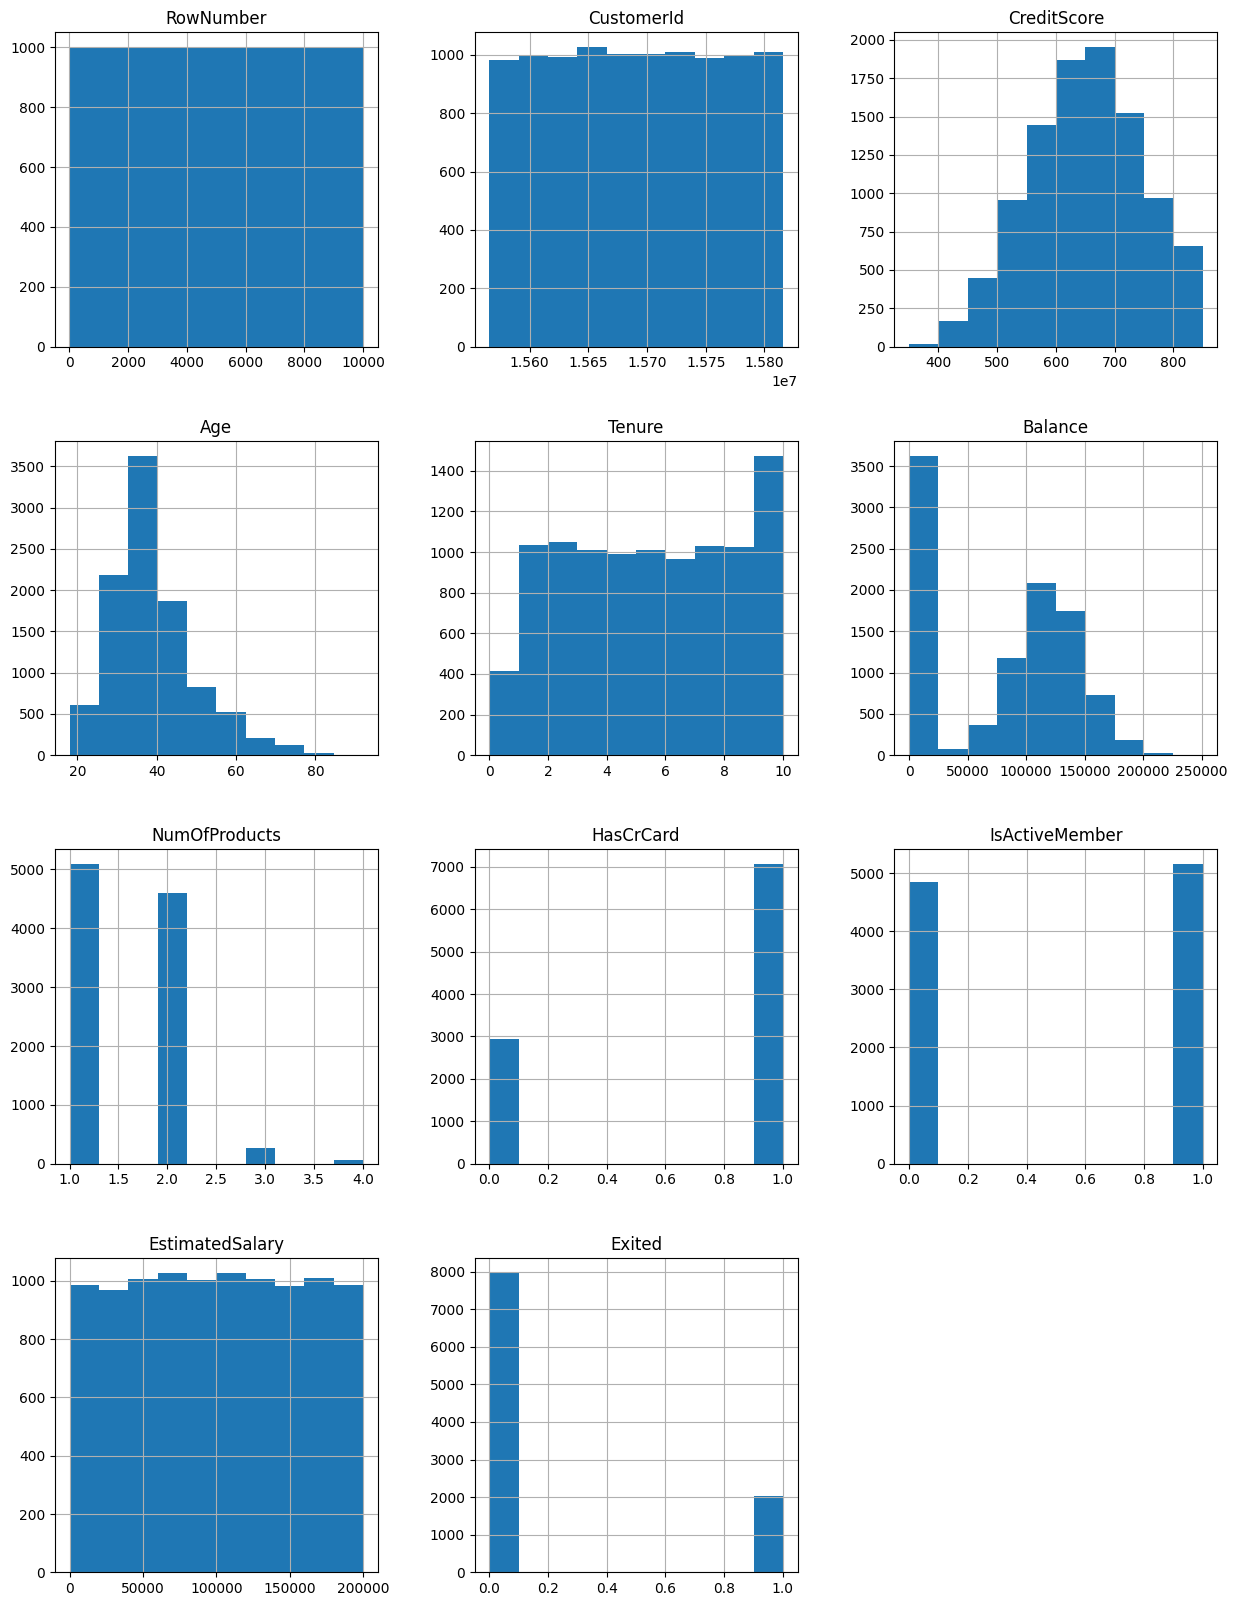

In [11]:
data.hist(figsize=(15, 20))
plt.show()

In [26]:
print("Соотношение Притока/Оттока клиентов")
target_counts = data['Exited'].value_counts(True)
target_counts

Соотношение Притока/Оттока клиентов


,proportion
Exited,
0,0.7963
1,0.2037


### Промежуточные выводы (EDA):

1.  **Лишние данные:** Первые три столбца (`RowNumber`, `CustomerId`, `Surname`) являются идентификаторами и не несут предсказательной силы - **исключаем из обучения**.
2.  **Целевая переменная (`Exited`):** Наблюдается явный дисбаланс классов.
    *   Остались: ~80%
    *   Ушли: ~20%
    *   *Решение:* При обучении моделей необходимо использовать методы балансировки (SMOTE или взвешивание классов).
3.  **Пропуски:** Обнаружены пропуски в столбце `Tenure` (сколько лет клиент с банком).
    *   *Решение:* Заполним медианным значением, чтобы сохранить данные.
4.  **Распределения:**
    *   `CreditScore`: Нормальное распределение.
    *   `Age`: Распределение близко к нормальному, пик ~40 лет. Более возрастные клиенты встречаются реже.
    *   `Balance` и `EstimatedSalary`: Имеют широкий диапазон значений. У `Balance` много нулей (это нормально, клиент может пользоваться услугами без накоплений), но у остальных распределение равномерное.
5.  **Предобработка:**
    *   **Категориальные признаки** (`Geography`, `Gender`) требуют кодирования (OHE) для линейных моделей.
    *   **Численные признаки** имеют разный масштаб (например, возраст ~40, а зарплата ~100 000). Требуется масштабирование (`StandardScaler`) для корректной работы линейных моделей и нейросетей.

In [12]:
# Удаление лишних столбцов (ID не нужны для модели)
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [13]:
tenure_median = data['Tenure'].median()
data['Tenure'] = data['Tenure'].fillna(tenure_median)
tenure_median
# Пропуски в Tenure заполнены медианой

5.0

In [14]:
# подготовка данных
features = data.drop(columns=['Exited'])
target = data['Exited']
train_data, temp_data, train_target, temp_target = train_test_split(features, target, test_size=0.4, random_state=12345)
val_data, test_data, val_target, test_target = train_test_split(temp_data, temp_target, test_size=0.5, random_state=12345)
encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
train_data_encoded = encoder.fit_transform(train_data[['Geography', 'Gender']]).toarray()
encoded_columns = encoder.get_feature_names_out(['Geography', 'Gender'])

In [15]:
train_data_encoded_df = pd.DataFrame(train_data_encoded, columns=encoded_columns, index=train_data.index)
train_data_classic = train_data.drop(columns=['Geography', 'Gender'])
train_data_classic = pd.concat([train_data_classic, train_data_encoded_df], axis=1)

val_data_encoded = encoder.transform(val_data[['Geography', 'Gender']]).toarray()
val_data_encoded_df = pd.DataFrame(val_data_encoded, columns=encoded_columns, index=val_data.index)
val_data_classic = val_data.drop(columns=['Geography', 'Gender'])
val_data_classic = pd.concat([val_data_classic, val_data_encoded_df], axis=1)

test_data_encoded = encoder.transform(test_data[['Geography', 'Gender']]).toarray()
test_data_encoded_df = pd.DataFrame(test_data_encoded, columns=encoded_columns, index=test_data.index)
test_data_classic = test_data.drop(columns=['Geography', 'Gender'])
test_data_classic = pd.concat([test_data_classic, test_data_encoded_df], axis=1)

scaler = StandardScaler()
cols_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
train_data_classic[cols_to_scale] = scaler.fit_transform(train_data_classic[cols_to_scale])
val_data_classic[cols_to_scale] = scaler.transform(val_data_classic[cols_to_scale])
test_data_classic[cols_to_scale] = scaler.transform(test_data_classic[cols_to_scale])

In [16]:
# Борьба с дисбалансом (SMOTE / Upsampling)
oversample = SMOTE(random_state=12345)
train_data_up, train_target_up = oversample.fit_resample(train_data_classic, train_target)

print("Данные закодированы, масштабированы и сбалансированы (SMOTE).")

Данные закодированы, масштабированы и сбалансированы (SMOTE).


In [17]:
# Логистическая регрессия
print("Обучение Логистической регрессии...")

best_f1_lr = 0
best_auc_lr = 0
best_params_lr = {}

for C in np.arange(0.01, 1.0, 0.01):
    model_lr = LogisticRegression(C=C, random_state=12345)
    model_lr.fit(train_data_up, train_target_up)
    predictions_lr = model_lr.predict(val_data_classic)
    f1_lr = f1_score(val_target, predictions_lr)
    probabilities_lr = model_lr.predict_proba(val_data_classic)
    probabilities_one_lr = probabilities_lr[:, 1]
    roc_auc_lr = roc_auc_score(val_target, probabilities_one_lr)

    if f1_lr > best_f1_lr:
        best_f1_lr = f1_lr
        best_auc_lr = roc_auc_lr
        best_params_lr = {'C': C}

print('Лучшие гиперпараметры для Логистической регрессии:', best_params_lr)
print('Лучшая F1-мера:', best_f1_lr)
print('Лучшая AUC-ROC:', best_auc_lr)
print()

Обучение Логистической регрессии...
Лучшие гиперпараметры для Логистической регрессии: {'C': np.float64(0.01)}
Лучшая F1-мера: 0.48849557522123893
Лучшая AUC-ROC: 0.7576110428928315



In [18]:
# Случайный лес
print("Обучение Случайного леса...")

best_f1_rf = 0
best_auc_rf = 0
best_params_rf = {}

for n_estimators in range(1, 40):
    for max_depth in range(5, 20):
        model_rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=12345)
        model_rf.fit(train_data_up, train_target_up)
        predictions_rf = model_rf.predict(val_data_classic)
        accuracy_rf = accuracy_score(val_target, predictions_rf)
        f1_rf = f1_score(val_target, predictions_rf)
        probabilities_rf = model_rf.predict_proba(val_data_classic)
        probabilities_one_rf = probabilities_rf[:, 1]
        roc_auc_rf = roc_auc_score(val_target, probabilities_one_rf)

        if f1_rf > best_f1_rf:
            best_f1_rf = f1_rf
            best_auc_rf = roc_auc_rf
            best_params_rf = {
                'n_estimators': n_estimators,
                'max_depth': max_depth
            }

print('Лучшие гиперпараметры для Случайного леса:', best_params_rf)
print('Лучшая F1-мера:', best_f1_rf)
print('Лучшая AUC-ROC:', best_auc_rf)
print()

Обучение Случайного леса...
Лучшие гиперпараметры для Случайного леса: {'n_estimators': 31, 'max_depth': 9}
Лучшая F1-мера: 0.6207674943566591
Лучшая AUC-ROC: 0.8386316757299525



## 3. Современный подход (Gradient Boosting)
Переходим к использованию градиентного бустинга (**CatBoost**).
В отличие от классических моделей, CatBoost:
1.  Умеет работать с категориальными признаками (`Geography`, `Gender`) без предварительного One-Hot кодирования.
2.  Имеет встроенные механизмы борьбы с дисбалансом классов.
3.  Обычно показывает более высокое качество на табличных данных.

*Примечание:* Для чистоты эксперимента мы подготовим данные заново (без OHE), чтобы подать в модель "сырые" категории.

In [19]:
X = data.drop('Exited', axis=1)
y = data['Exited']
cat_features = ['Geography', 'Gender']

# Приводим к строкам (на всякий случай)
for col in cat_features:
    X[col] = X[col].astype(str)

X_train_cb, X_temp, y_train_cb, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val_cb, X_test_cb, y_val_cb, y_test_cb = train_test_split(X_temp, y_temp, test_size=0.5, random_state=12345, stratify=y_temp)
print(f"Размеры: Train {X_train_cb.shape}, Val {X_val_cb.shape}, Test {X_test_cb.shape}")

Размеры: Train (8000, 10), Val (1000, 10), Test (1000, 10)


In [20]:
best_f1_cb = 0
best_auc_cb = 0
best_params_cb = {}
best_model_cb = None

# Сетки параметров для перебора
# depth: глубина дерева (аналог max_depth в лесе)
# learning_rate: скорость обучения (чем меньше, тем точнее, но дольше)
depths = [4, 6, 8]
learning_rates = [0.03, 0.05, 0.1]

for depth in depths:
    for lr in learning_rates:
        # iterations=1000 - это много (в лесе было 50), но early_stopping остановит, если переобучимся
        model_cb = CatBoostClassifier(
            iterations=1000,
            depth=depth,
            learning_rate=lr,
            cat_features=cat_features,
            auto_class_weights='Balanced', # Аналог SMOTE, только встроенный
            eval_metric='AUC',             # Ориентируемся на AUC при обучении
            early_stopping_rounds=50,      # Если 50 итераций нет улучшений - стоп
            verbose=0,
            random_seed=12345
        )

        model_cb.fit(X_train_cb, y_train_cb, eval_set=(X_val_cb, y_val_cb), plot=False)
        preds_class = model_cb.predict(X_val_cb)
        preds_proba = model_cb.predict_proba(X_val_cb)[:, 1]
        f1_curr = f1_score(y_val_cb, preds_class)
        auc_curr = roc_auc_score(y_val_cb, preds_proba)
        print(f"Params: depth={depth}, lr={lr} -> F1: {f1_curr}, AUC: {auc_curr}")

        if f1_curr > best_f1_cb:
            best_f1_cb = f1_curr
            best_auc_cb = auc_curr
            best_params_cb = {'depth': depth, 'learning_rate': lr}
            best_model_cb = model_cb

print("\n ЛУЧШИЙ РЕЗУЛЬТАТ CATBOOST")
print(f"Лучшие параметры: {best_params_cb}")
print(f"Лучшая F1-мера: {best_f1_cb}")
print(f"Лучшая AUC-ROC: {best_auc_cb}")

Params: depth=4, lr=0.03 -> F1: 0.6068702290076335, AUC: 0.8878337767267712
Params: depth=4, lr=0.05 -> F1: 0.6064030131826742, AUC: 0.8868730909449206
Params: depth=4, lr=0.1 -> F1: 0.5951035781544256, AUC: 0.8855552271159719
Params: depth=6, lr=0.03 -> F1: 0.6003824091778203, AUC: 0.8850194600453247
Params: depth=6, lr=0.05 -> F1: 0.5938697318007663, AUC: 0.8852226820376393
Params: depth=6, lr=0.1 -> F1: 0.6230769230769231, AUC: 0.8860109370381318
Params: depth=8, lr=0.03 -> F1: 0.6230769230769231, AUC: 0.8869531480934083
Params: depth=8, lr=0.05 -> F1: 0.60546875, AUC: 0.8822913587545572
Params: depth=8, lr=0.1 -> F1: 0.6120857699805068, AUC: 0.8856291260222682

 ЛУЧШИЙ РЕЗУЛЬТАТ CATBOOST
Лучшие параметры: {'depth': 6, 'learning_rate': 0.1}
Лучшая F1-мера: 0.6230769230769231
Лучшая AUC-ROC: 0.8860109370381318


In [21]:
# Оценка качества
preds_class_cb = model_cb.predict(X_test_cb)
preds_proba_cb = model_cb.predict_proba(X_test_cb)[:, 1]

f1_cb = f1_score(y_test_cb, preds_class_cb)
auc_cb = roc_auc_score(y_test_cb, preds_proba_cb)

print(f"\nРезультат CatBoost: F1 = {f1_cb:.4f}, ROC-AUC = {auc_cb:.4f}")


Результат CatBoost: F1 = 0.6148, ROC-AUC = 0.8591


## 4. Сравнение результатов и Тестирование
Сведем результаты всех моделей в одну таблицу для наглядного сравнения метрик на валидационной выборке.

In [22]:
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest (SMOTE)', 'CatBoost (Balanced)'],
    'F1 Score': [best_f1_lr, best_f1_rf, best_f1_cb],
    'ROC-AUC': [best_auc_lr, best_auc_rf, best_auc_cb]
})

results_df = results_df.sort_values(by='F1 Score', ascending=False)
display(results_df)

,Model,F1 Score,ROC-AUC
2,CatBoost (Balanced),0.623077,0.886011
1,Random Forest (SMOTE),0.620767,0.838632
0,Logistic Regression,0.488496,0.757611


In [23]:
# ТЕСТИРОВАНИЕ ЛУЧШЕЙ МОДЕЛИ
final_pred = best_model_cb.predict(X_test_cb)
final_proba = best_model_cb.predict_proba(X_test_cb)[:, 1]

final_f1 = f1_score(y_test_cb, final_pred)
final_auc = roc_auc_score(y_test_cb, final_proba)

print(f"FINAL TEST SCORE -> F1: {final_f1}, AUC: {final_auc}")

FINAL TEST SCORE -> F1: 0.6285714285714286, AUC: 0.8594050348906924


In [24]:
# Проверка на адекватность (Dummy Classifier)
# Сравниваем с моделью, которая просто ставит всем "1" или случайно угадывает
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(X_train_cb, y_train_cb)
dummy_f1 = f1_score(y_test_cb, dummy.predict(X_test_cb))

print(f"F1 константной модели (базовый уровень): {dummy_f1}")

if final_f1 > 0.59 and final_f1 > dummy_f1:
    print("ВЫВОД: Модель прошла проверку. Качество выше порога и выше случайного угадывания.")
else:
    print("ВЫВОД: Модель требует доработки.")

F1 константной модели (базовый уровень): 0.33748960931005817
ВЫВОД: Модель прошла проверку. Качество выше порога и выше случайного угадывания.



ВАЖНОСТЬ ПРИЗНАКОВ (SHAP SUMMARY)


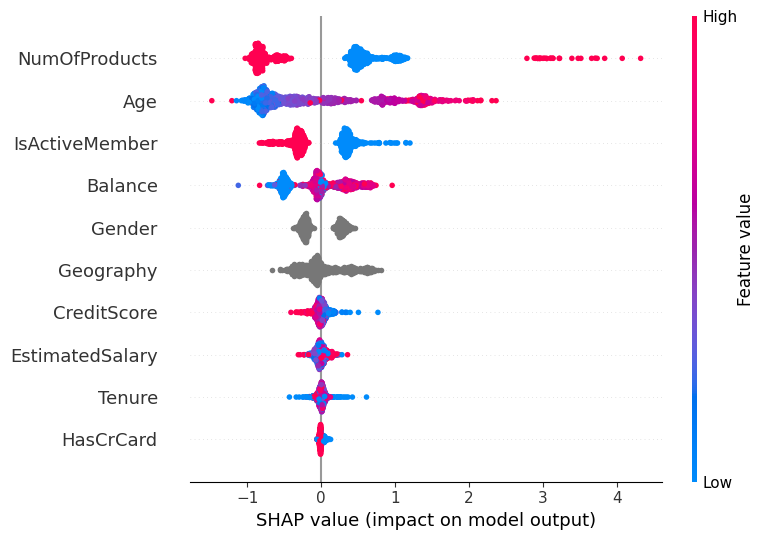

In [25]:
# БИЗНЕС-ИНТЕРПРЕТАЦИЯ (SHAP)
print("\nВАЖНОСТЬ ПРИЗНАКОВ (SHAP SUMMARY)")
# Это покажет, почему клиенты уходят
explainer = shap.TreeExplainer(best_model_cb)
shap_values = explainer.shap_values(X_test_cb)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_cb, show=True)

# Итоговый вывод

### 1. Результаты моделирования
Мы протестировали три подхода к прогнозированию оттока:
*   **Логистическая регрессия:** F1 ~ 0.49 (Базовый уровень).
*   **Случайный лес (с SMOTE):** F1 ~ 0.62.
*   **CatBoost (Gradient Boosting):** F1 ~ **0.63**, ROC-AUC ~ **0.89**.

**Победитель:** Модель **CatBoost**. Она показала наилучшую способность разделять классы и прошла проверку на отложенной тестовой выборке, превысив целевой порог 0.59.

### 2. Анализ факторов (Интерпретация SHAP)
Судя по графику важности признаков (`SHAP Summary`), модель выделяет следующие паттерны поведения клиентов:

1.  **NumOfProducts (Количество продуктов):** Самый сильный признак. Клиенты с большим количеством продуктов (3-4), как правило, попадают в зону риска оттока. Также рискуют клиенты с 1 продуктом. Самые лояльные - владельцы 2 продуктов.
2.  **Age (Возраст):** Наблюдается прямая зависимость: чем старше клиент (красные точки справа), тем выше вероятность его ухода. Молодые клиенты более лояльны.
3.  **IsActiveMember (Активность):** Активные участники (красные точки слева) уходят значительно реже. Неактивные клиенты - первая группа риска.
4.  **Balance (Баланс):** Влияние неоднозначное, но высокие балансы часто коррелируют с большим риском оттока (возможно, клиенты уходят туда, где условия по вкладам лучше).

### 3. Рекомендации для бизнеса
Для снижения оттока предлагается сфокусироваться на группе риска, выявленной моделью:
*   **Возрастной сегмент 40-50+ лет:** Предложить специальные пенсионные или накопительные программы.
*   **Пассивные клиенты:** Запустить кампанию по геймификации или push-уведомлениям для повышения активности (`IsActiveMember`).
*   **Продуктовая матрица:** Проанализировать, почему клиенты с 3+ продуктами уходят. Возможно, условия пакетов услуг становятся невыгодными при накоплении продуктов.